In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
import keras
import theano
import random
import os
import pickle

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
theano.__version__

'0.9.0'

## Set plotting style

In [4]:
plt.rcParams["patch.force_edgecolor"] = True
sns.set_style('whitegrid',
              {'axes.grid': True,
               'grid.linestyle': u'--',
               'axes.edgecolor': '0.1',
               'axes.labelcolor': '0',
               'axes.labelsize': 15,
               'axes.titlesize': 15,
               'legend.fontsize': 15,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               })

## The directory that contains information about the model parameters

In [5]:
model_name = 'Random_UTR_CNN'
model_params_dir = '../Results/{0}.Hyperparam.Opt/'.format(model_name)

## Create a directory to save results:

(if it doesn't already exist)

In [6]:
results_dir = '../Results/{0}.ModelPredictions/'.format(model_name)

if not os.path.exists(model_params_dir):
    os.mkdir(model_params_dir)

## Load the cleaned up data.

The csv should be tab-separated. The read counts are log2.

In [7]:
data_dir = '../Data/'

data = pd.read_csv(data_dir + 'Random_UTRs.csv', index_col = 0)

## One-hot encoding of the sequences.

i.e. we're converting the sequences from being represented as a 50 character string of bases to a 4x50 matrix of 1's and 0's, with each row corresponding to a base and every column a position in the UTR.

Note that we're doing the indexing a little differently than in Notebook 1 -- see comments in function

In [8]:
# one hot encoding of UTRs
# X = one hot encoding matrix
# Y = growth rates

def one_hot_encoding(df, seq_column, expression):
    
    bases = ['A','C','G','T']
    base_dict = dict(zip(bases,range(4))) # {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    n = len(df)
    
    # length of the UTR sequence
    # we also add 10 empty spaces to either side
    total_width = df[seq_column].str.len().max() + 20
    
    # initialize an empty numpy ndarray of the appropriate size
    X = np.zeros((n, 1, 4, total_width))
    
    # an array with the sequences that we will one-hot encode
    seqs = df[seq_column].values
    
    # loop through the array of sequences to create an array that keras will actually read
    for i in range(n):
        seq = seqs[i]
        
        # loop through each individual sequence, from the 5' to 3' end
        for b in range(len(seq)):
            # this will assign a 1 to the appropriate base and position for this UTR sequence
            # Note that this looks different than the same function in Notebook #1, but it does
            # the same thing.
            X[i, 0, base_dict[seq[b]], b + 10 + 50 - len(seq)] = 1.
    
        # keep track of where we are
        if (i%10000)==0:
            print i,
        
    X = X.astype(theano.config.floatX)
    Y = np.asarray(df[expression].values,
                   dtype = theano.config.floatX)[:, np.newaxis]
    
    return X, Y, total_width

In [9]:
X, Y, total_width = one_hot_encoding(data, 'UTR', 'growth_rate')

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000 400000 410000 420000 430000 440000 450000 460000 470000 480000


## Split the data into test and training sets, just like before

If we have more reads for a given UTR at the outset, we can be more confident that we have made an accurate measurement. For this reason, we've used those UTRs with the most reads to test our model on, because these should have the least experimental noise. We held out the UTRs that fell in top 5% of reads at the first time point as our test set.

In [10]:
# a sorted numpy array of UTR indexes, from least reads to most reads
sorted_inds = data.sort_values('t0').index.values

train_inds = sorted_inds[:int(0.95*len(sorted_inds))] # 95% of the data as the training set
test_inds = sorted_inds[int(0.95*len(sorted_inds)):] # UTRs with most reads at time point 0 as the test set

# set the seed before randomly shuffling the data
seed = 0.5
random.shuffle(train_inds, lambda :seed)

## Load model trained on random 5' UTRs

In [11]:
!ls {model_params_dir}

hyperparam_test.pkl        model_weights.h5
hyperparam_test_binary.pkl model_weights.hdf5
model_arch.json


In [12]:
model = keras.models.model_from_json(open(model_params_dir + 'model_arch.json').read())
model.load_weights(model_params_dir + 'model_weights.hdf5')
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
Y_pred = model.predict(X, verbose=1)

489344/489348 [============================>.] - ETA: 0s

## Plot results

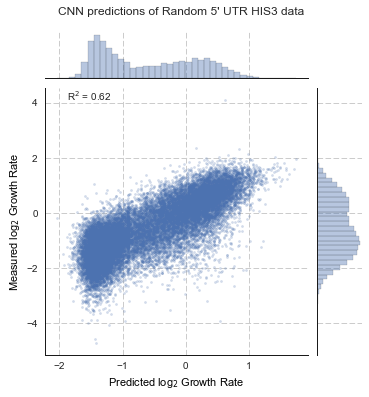

In [14]:
# data
x = Y_pred[test_inds].flatten()
y = Y[test_inds].flatten()

# calculate R^2
r2 = scipy.stats.pearsonr(x, y)[0]**2


g = sns.jointplot(x,
                  y,
                  stat_func = None,
                  kind = 'scatter',
                  s = 5,
                  alpha = 0.25,
                  size = 5)

g.ax_joint.set_xlabel('Predicted log$_2$ Growth Rate')
g.ax_joint.set_ylabel('Measured log$_2$ Growth Rate')


text = "R$^2$ = {:0.2}".format(r2)
plt.annotate(text, xy=(-5.5, 0.95), xycoords='axes fraction')

plt.title("CNN predictions of Random 5' UTR HIS3 data", x = -3, y = 1.25)

## Save data and predictions to csv

In [15]:
data['pred_growth_rate'] = Y_pred

In [ ]:
data.to_csv(results_dir + 'Random_UTRs_with_predictions.csv')